# Model 2: Vision Transformer

In [ ]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/aider_data.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

Mounted at /content/drive/


In [ ]:
import matplotlib.pyplot as plt
import itertools  # Import 'itertools' for iterators and looping



In [ ]:
from sklearn.metrics import (  # Import various metrics from scikit-learn
    accuracy_score,  # For calculating accuracy
    roc_auc_score,  # For ROC AUC score
    confusion_matrix,  # For confusion matrix
    classification_report,  # For classification report
    f1_score  # For F1 score
)

In [ ]:
# Import Image from PIL with an alias
from PIL import Image as PILImage


In [ ]:
!pip install accelerate -U
!pip install datasets
# Necessary imports
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from datasets import Dataset, Image, ClassLabel
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments, Trainer
from torchvision.transforms import Compose, Normalize, Resize, ToTensor
import torch
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.5 MB/s eta 0:00:00


In [ ]:
# Load and process the dataset
file_names = []
labels = []

dataset_path = Path('/tmp/AIDER')

# Define the labels to exclude
excluded_labels = []

# Traverse the dataset directory
for label_dir in dataset_path.iterdir():
    if label_dir.is_dir() and label_dir.name not in excluded_labels:
        label = label_dir.name
        for file in tqdm(label_dir.glob('**/*.*'), desc=f"Processing {label}"):
            labels.append(label)
            file_names.append(str(file))

# df = pd.DataFrame({"image": file_names, "label": labels})
# print(df.head())



Processing normal: 4390it [00:00, 106210.02it/s]
Processing fire: 521it [00:00, 80051.01it/s]
Processing traffic_incident: 485it [00:00, 70320.71it/s]
Processing collapsed_building: 511it [00:00, 91437.26it/s]
Processing flooded_areas: 526it [00:00, 37367.32it/s]


In [ ]:
df = pd.DataFrame({"image": file_names, "label": labels})
print(df)

                                             image          label
0           /tmp/AIDER/normal/normal_image0107.jpg         normal
1           /tmp/AIDER/normal/normal_image3284.jpg         normal
2           /tmp/AIDER/normal/normal_image1929.jpg         normal
3           /tmp/AIDER/normal/normal_image3399.jpg         normal
4           /tmp/AIDER/normal/normal_image2113.jpg         normal
...                                            ...            ...
6428  /tmp/AIDER/flooded_areas/flood_image0324.jpg  flooded_areas
6429  /tmp/AIDER/flooded_areas/flood_image0075.jpg  flooded_areas
6430  /tmp/AIDER/flooded_areas/flood_image0164.jpg  flooded_areas
6431  /tmp/AIDER/flooded_areas/flood_image0320.jpg  flooded_areas
6432  /tmp/AIDER/flooded_areas/flood_image0153.jpg  flooded_areas

[6433 rows x 2 columns]


In [ ]:
df['image'][0]

'/tmp/AIDER/normal/normal_image0107.jpg'

In [ ]:
exclude_files = []

In [ ]:
from PIL import Image as PILImage
import os
import glob

def preprocess_and_filter_images(folder_path):
    valid_images = []
    for img_path in glob.glob(os.path.join(folder_path, '**/*'), recursive=True):
        if os.path.isfile(img_path) and img_path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):
            try:
                with PILImage.open(img_path) as img:
                    img.verify()  # Verify the integrity of the file
                    valid_images.append(img_path)
            except Exception as e:
                print('Problematic file:', img_path, 'Error:', e)
                exclude_files.append(img_path)
                # Optionally, you can remove or move the corrupted file
    return valid_images

# Use this function to filter out invalid images before creating your dataset
folder_path = '/input/aider-data-1/AIDER'
filtered_image_paths = preprocess_and_filter_images(folder_path)

In [ ]:
exclude_files

[]

In [ ]:
# Assuming 'df' is your DataFrame with a column 'image' that contains the file paths
df = pd.DataFrame.from_dict({"image": file_names, "label": labels})  # Example DataFrame creation

# Filter out the rows corresponding to the problematic files
df = df[~df['image'].isin(exclude_files)]

In [ ]:
df['label'].unique()

array(['normal', 'fire', 'traffic_incident', 'collapsed_building',
       'flooded_areas'], dtype=object)

In [ ]:
# Create a Hugging Face Dataset
dataset = Dataset.from_pandas(df).cast_column("image", Image())

In [ ]:
# Process labels
labels_list = sorted(set(labels))
label2id = {label: i for i, label in enumerate(labels_list)}
id2label = {i: label for label, i in label2id.items()}


In [ ]:
id2label

{0: 'collapsed_building',
 1: 'fire',
 2: 'flooded_areas',
 3: 'normal',
 4: 'traffic_incident'}

In [ ]:
def map_label2id(batch):
    batch['label'] = [label2id[label] for label in batch['label']]
    return batch

dataset = dataset.map(map_label2id, batched=True)
dataset = dataset.cast_column('label', ClassLabel(num_classes=len(label2id), names=list(label2id.keys())))


Map:   0%|          | 0/6433 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/6433 [00:00<?, ? examples/s]

In [ ]:
# Split dataset into train and test
dataset = dataset.train_test_split(test_size=0.2, shuffle=True)
train_data = dataset['train']
test_data = dataset['test']

In [ ]:
# Image preprocessing
model_str = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_str)
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
_train_transforms = Compose([
    Resize((size, size)),
    ToTensor(),
    Normalize(mean=image_mean, std=image_std)
])

In [ ]:
import torchvision.transforms as T

# Define the transformation pipeline
_train_transforms = T.Compose([
    T.Resize((224, 224)),  # Example resize, adjust as needed
    T.ToTensor(),
    # Add other transformations as needed
])

def train_transforms(examples):
    pixel_values = []
    for img in examples['image']:
        try:
            # Convert the image to RGB (if not already in this mode)
            img = img.convert('RGB')
            # Apply the transformations
            transformed_img = _train_transforms(img)
            pixel_values.append(transformed_img)
        except Exception as e:
            print('Error processing an image:', e)
            continue

    examples['pixel_values'] = pixel_values
    return examples

# Apply the transform to your dataset
train_data = train_data.map(train_transforms, batched=True)



Map:   0%|          | 0/5146 [00:00<?, ? examples/s]

In [ ]:
from PIL import Image as PILImage
import os
import glob

def preprocess_and_filter_images(folder_path):
    valid_images = []
    for img_path in glob.glob(os.path.join(folder_path, '**/*'), recursive=True):
        if os.path.isfile(img_path) and img_path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):
            try:
                with PILImage.open(img_path) as img:
                    img.verify()  # Verify the integrity of the file
                    valid_images.append(img_path)
            except Exception as e:
                print('Problematic file:', img_path, 'Error:', e)
                # Optionally, you can remove or move the corrupted file
    return valid_images

# Use this function to filter out invalid images before creating your dataset
folder_path = '/input/aider-data-1/AIDER'
filtered_image_paths = preprocess_and_filter_images(folder_path)

In [ ]:
df

,image,label
0,/tmp/AIDER/normal/normal_image0107.jpg,normal
1,/tmp/AIDER/normal/normal_image3284.jpg,normal
2,/tmp/AIDER/normal/normal_image1929.jpg,normal
3,/tmp/AIDER/normal/normal_image3399.jpg,normal
4,/tmp/AIDER/normal/normal_image2113.jpg,normal
...,...,...
6428,/tmp/AIDER/flooded_areas/flood_image0324.jpg,flooded_areas
6429,/tmp/AIDER/flooded_areas/flood_image0075.jpg,flooded_areas
6430,/tmp/AIDER/flooded_areas/flood_image0164.jpg,flooded_areas
6431,/tmp/AIDER/flooded_areas/flood_image0320.jpg,flooded_areas


13556

In [ ]:
# Model setup
model = ViTForImageClassification.from_pretrained(model_str, num_labels=len(labels_list))
model.config.id2label = id2label
model.config.label2id = label2id

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
args = TrainingArguments(
    output_dir='disaster_images_model',
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    learning_rate=3e-5,
    weight_decay=0.01,
    evaluation_strategy='epoch',  # Changed to 'epoch' to match save_strategy
    save_strategy='epoch',
    remove_unused_columns=False,
    load_best_model_at_end=True
)


In [ ]:
# Trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_data,
    eval_dataset=test_data

)

In [ ]:
train_data

Dataset({
    features: ['image', 'label', '__index_level_0__', 'pixel_values'],
    num_rows: 5146
})

In [ ]:
# Set the format of the dataset to Python dictionaries
train_data.set_format(type='python', columns=['image', 'label'])

# Inspect the first few examples
for i in range(5):
    example = train_data[i]
    print(f"Example {i}:")
    print("Image:", type(example['image']), "->", example['image'])
    print("Label:", example['label'])
    print()

# Reset the format of the dataset
train_data.reset_format()


Example 0:
Image: <class 'PIL.JpegImagePlugin.JpegImageFile'> -> <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x360 at 0x7D8764114E80>
Label: 3

Example 1:
Image: <class 'PIL.JpegImagePlugin.JpegImageFile'> -> <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=342x343 at 0x7D8755DF7880>
Label: 3

Example 2:
Image: <class 'PIL.JpegImagePlugin.JpegImageFile'> -> <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x360 at 0x7D87A5B93970>
Label: 3

Example 3:
Image: <class 'PIL.JpegImagePlugin.JpegImageFile'> -> <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=399x360 at 0x7D8755DF6B00>
Label: 3

Example 4:
Image: <class 'PIL.JpegImagePlugin.JpegImageFile'> -> <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=670x670 at 0x7D8755DF7A30>
Label: 4



In [ ]:
from torchvision.transforms import functional as F

def collate_fn(batch, desired_size=(224, 224)):
    pixel_values = []
    for item in batch:
        image = item['image']
        # Convert to RGB (3 channels)
        image = image.convert('RGB')
        # Resize the image to the desired size
        image = F.resize(image, desired_size)
        # Convert to tensor
        image = F.to_tensor(image)
        pixel_values.append(image)

    labels = [item['label'] for item in batch]
    return {'pixel_values': torch.stack(pixel_values), 'labels': torch.tensor(labels)}

# Use this collate_fn in your Trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn
)


In [ ]:
# Start training
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.377600,0.104049
2,0.083500,0.091499
3,0.041600,0.071199


TrainOutput(global_step=1932, training_loss=0.13476336471289088, metrics={'train_runtime': 1799.9091, 'train_samples_per_second': 8.577, 'train_steps_per_second': 1.073, 'total_flos': 1.1963535024192676e+18, 'train_loss': 0.13476336471289088, 'epoch': 3.0})

In [ ]:
# Evaluate the model
trainer.evaluate()

{'eval_loss': 0.07119900733232498,
 'eval_runtime': 17.7902,
 'eval_samples_per_second': 72.343,
 'eval_steps_per_second': 9.05,
 'epoch': 3.0}

In [ ]:
# Use the trained 'trainer' to make predictions on the 'test_data'.
outputs = trainer.predict(test_data)

# Print the metrics obtained from the prediction outputs.
print(outputs.metrics)

{'test_loss': 0.07119900733232498, 'test_runtime': 18.9344, 'test_samples_per_second': 67.972, 'test_steps_per_second': 8.503}


Accuracy: 0.9868
F1 Score: 0.9793


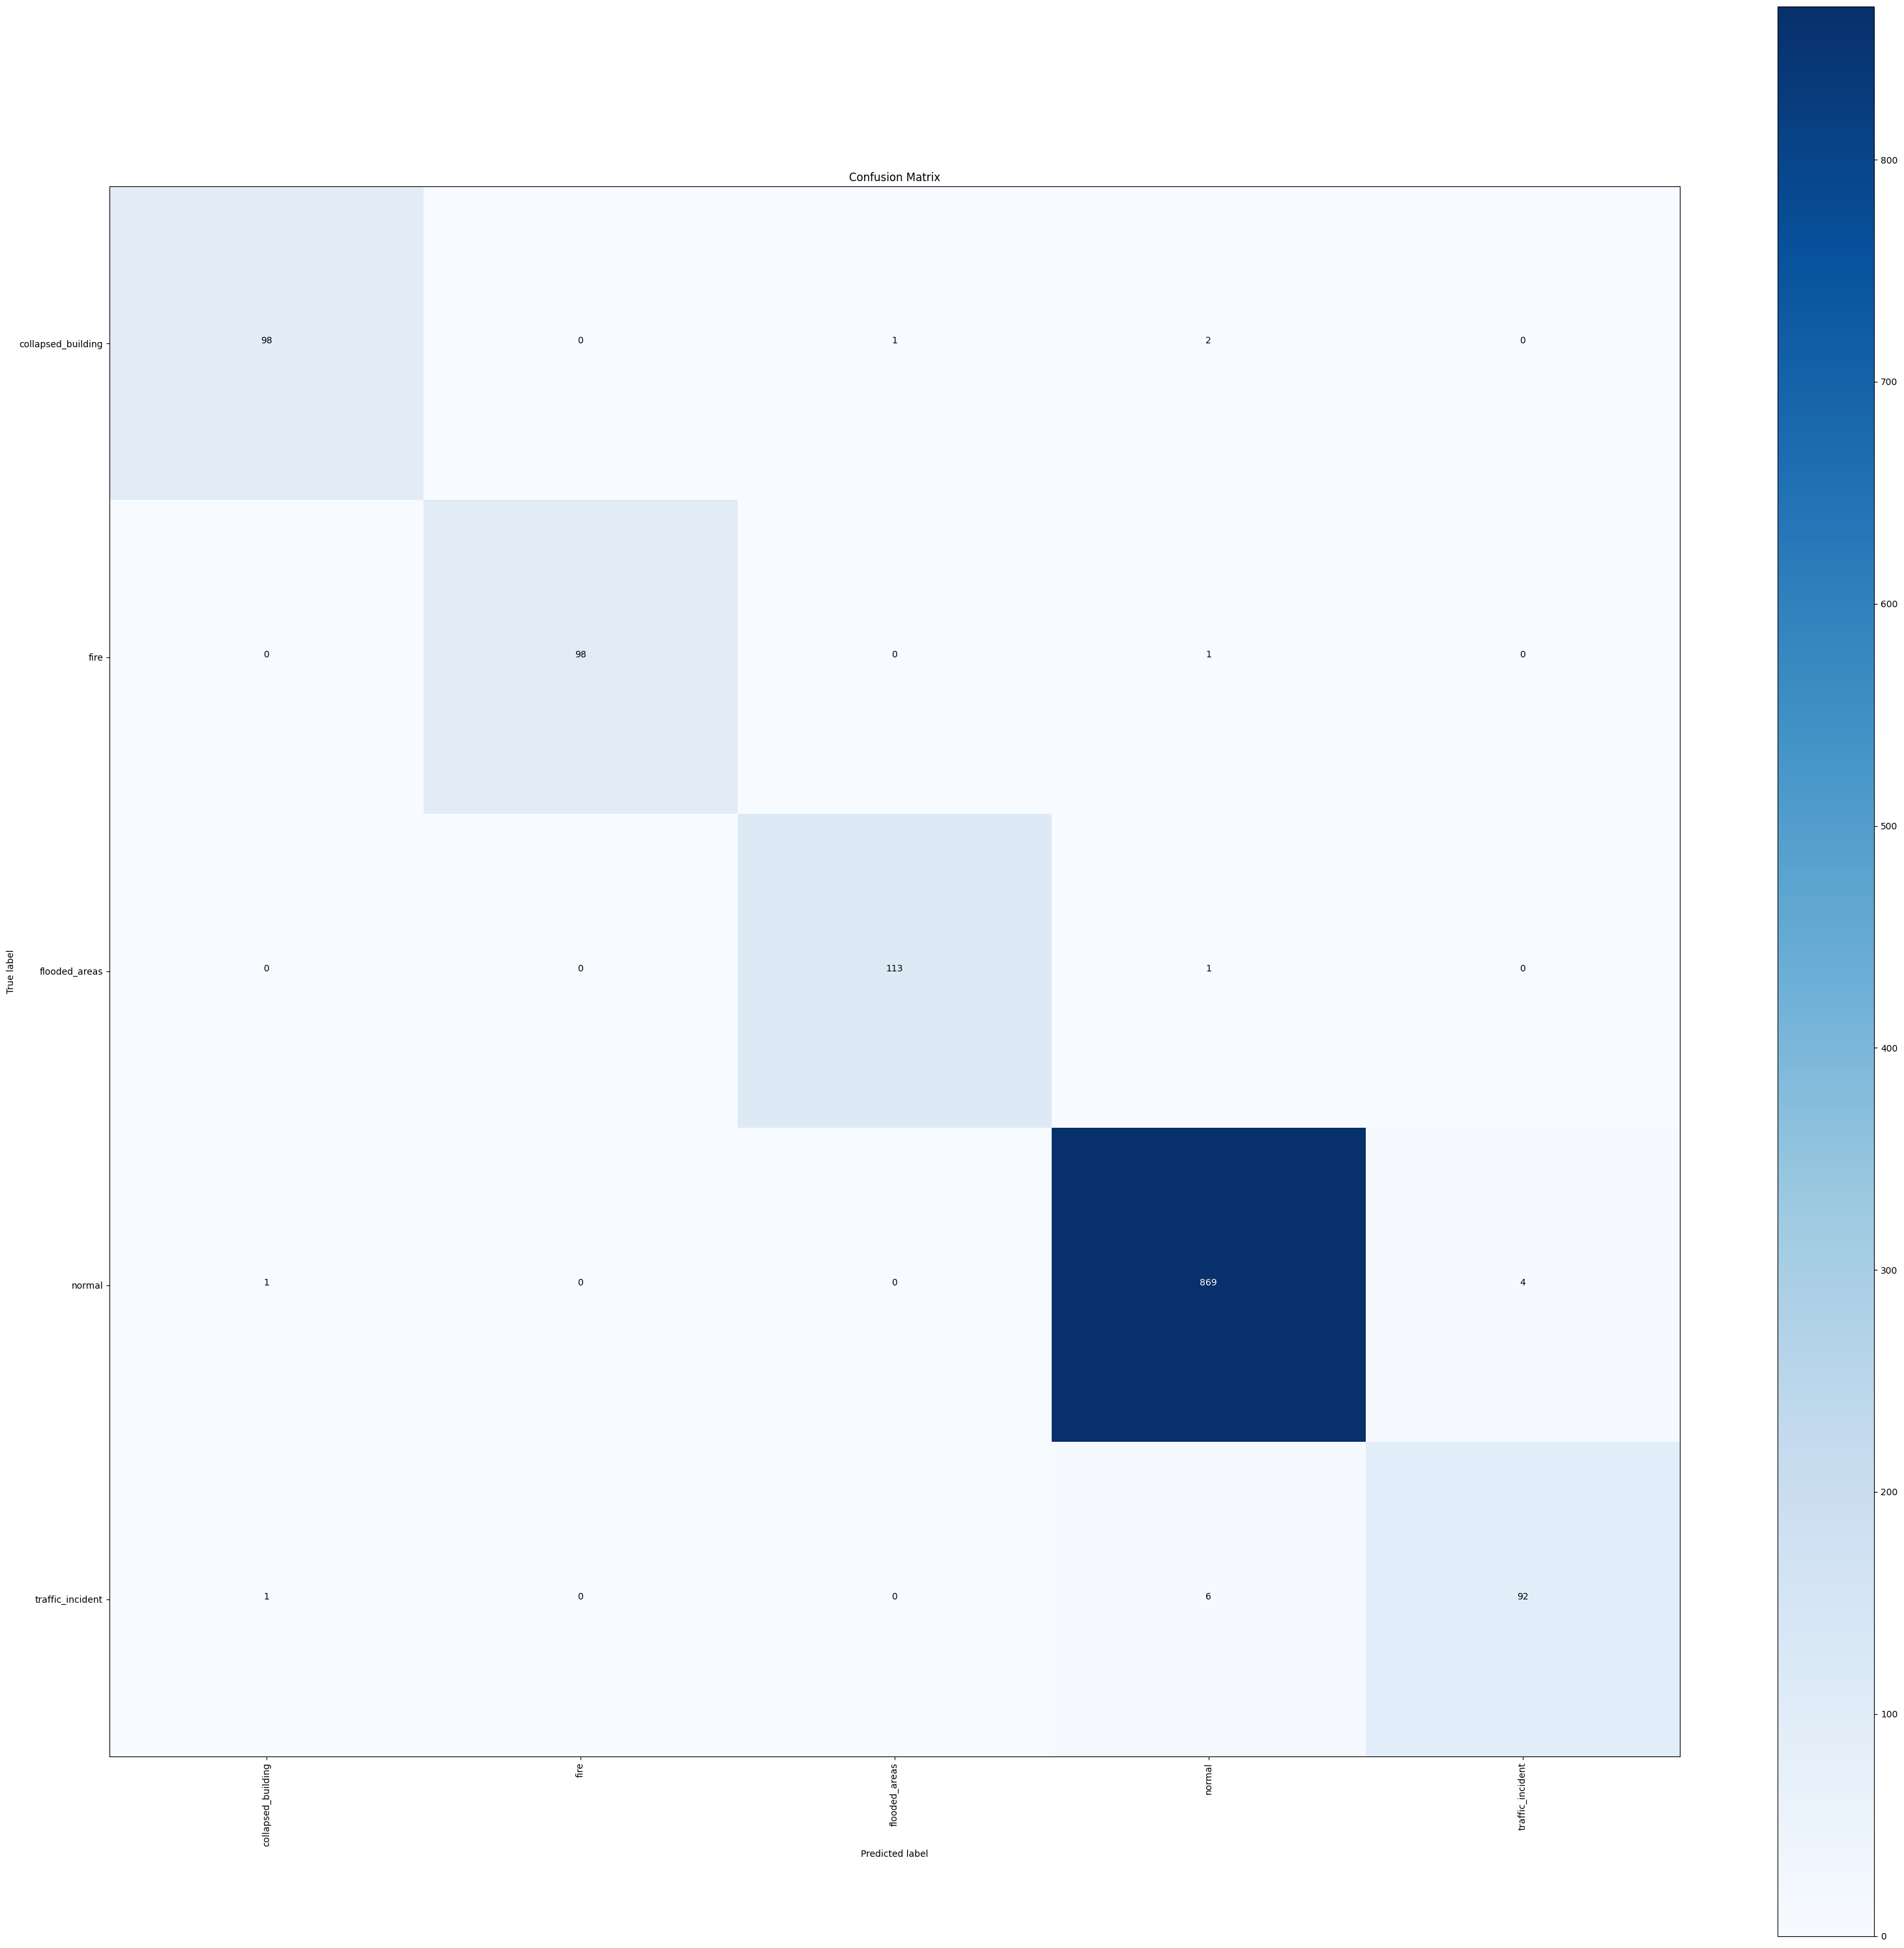


Classification report:

                    precision    recall  f1-score   support

collapsed_building     0.9800    0.9703    0.9751       101
              fire     1.0000    0.9899    0.9949        99
     flooded_areas     0.9912    0.9912    0.9912       114
            normal     0.9886    0.9943    0.9914       874
  traffic_incident     0.9583    0.9293    0.9436        99

          accuracy                         0.9868      1287
         macro avg     0.9836    0.9750    0.9793      1287
      weighted avg     0.9867    0.9868    0.9867      1287



In [ ]:
# Extract the true labels from the model outputs
y_true = outputs.label_ids

# Predict the labels by selecting the class with the highest probability
y_pred = outputs.predictions.argmax(1)

# Define a function to plot a confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    # Create a figure with a specified size
    plt.figure(figsize=figsize)

    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot
    plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix if there are a small number of labels
if len(labels_list) <= 250:
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix using the defined function
    plot_confusion_matrix(cm, labels_list, figsize=(32, 30))

# Finally, display classification report
print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

In [ ]:
# Save the trained model: This line of code is responsible for saving the model
# that has been trained using the trainer object. It will serialize the model
# and its associated weights, making it possible to reload and use the model
# in the future without the need to retrain it.
trainer.save_model()
